In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
from scipy.optimize import curve_fit


#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

Welcome to JupyROOT 6.26/06


In [2]:
import ROOT

In [3]:
Pass="2"
config="2"
useGrinch=False
base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/Timing"


In [4]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')



W2min: 0
W2max: 1.5
dxmin: -0.481
dxmax: 0.498
dymin: -0.822
dymax: 0.8
dybgmin: -1.4
dybgmax: 1.4
Q2: 3
Coin Min: 128 Coin Max: 139


In [10]:
hodomeantime_gen2 = np.load("DB/timing/hodomeantime_offsets_gen2.npy").astype(float)


In [11]:
generic=np.load(f"{base_dir}/timing0.npz")


In [12]:
len(generic["HODOtmean"])

2000000

In [13]:
"""i=0
all_bars=[]
all_times=[]
while os.path.exists(f"{base_dir}/timing{i}.npz"):
    # load your i-th chunk here
    print(i)
    data = np.load(f"{base_dir}/timing{i}.npz")  # or .npy/.h5 depending on your format


    HODOraw = data["HODOtmean"]
    bb_rftime = data["bb_rftime"]
    primarybarid = np.transpose(data["barid"])[0]

    dtRF = HODOraw - bb_rftime


    all_bars.append(primarybarid)
    all_times.append(dtRF)
    i+=1
all_bars = np.concatenate(all_bars)
all_times = np.concatenate(all_times)"""


'i=0\nall_bars=[]\nall_times=[]\nwhile os.path.exists(f"{base_dir}/timing{i}.npz"):\n    # load your i-th chunk here\n    print(i)\n    data = np.load(f"{base_dir}/timing{i}.npz")  # or .npy/.h5 depending on your format\n\n\n    HODOraw = data["HODOtmean"]\n    bb_rftime = data["bb_rftime"]\n    primarybarid = np.transpose(data["barid"])[0]\n\n    dtRF = HODOraw - bb_rftime\n\n\n    all_bars.append(primarybarid)\n    all_times.append(dtRF)\n    i+=1\nall_bars = np.concatenate(all_bars)\nall_times = np.concatenate(all_times)'

In [15]:
"""plt.figure(figsize=(10, 6))
h = plt.hist2d(bars, times, bins=[n_bars, bins_y], range=[[0, n_bars], list(y_range)], cmap='viridis')
plt.colorbar(h[3], label='Counts')
plt.xlabel("Primary Hodoscope Bar ID")
plt.ylabel(r"$t_\mathrm{raw} - t_\mathrm{RF}$ (ns)")
plt.title("Timing Residual vs Bar ID")
plt.tight_layout()
plt.show()"""


'plt.figure(figsize=(10, 6))\nh = plt.hist2d(bars, times, bins=[n_bars, bins_y], range=[[0, n_bars], list(y_range)], cmap=\'viridis\')\nplt.colorbar(h[3], label=\'Counts\')\nplt.xlabel("Primary Hodoscope Bar ID")\nplt.ylabel(r"$t_\\mathrm{raw} - t_\\mathrm{RF}$ (ns)")\nplt.title("Timing Residual vs Bar ID")\nplt.tight_layout()\nplt.show()'

In [15]:
genericMaster = {}

def doit():
    base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/Timing"
    i = 0
    print(f"NumPy array directory = {base_dir}")
    while os.path.exists(f"{base_dir}/timing{i}.npz"):
        #if i >5:
        #    break
        print(f"Loading in file {i}")
        file_path = f"{base_dir}/timing{i}.npz"
        data = np.load(file_path)

        for key in data.files:
            if key not in genericMaster:
                genericMaster[key] = data[key]
            else:
                genericMaster[key] = np.concatenate((genericMaster[key], data[key]))

        data.close()
        i += 1

    print(f"Loaded {i} files into genericMaster.")


In [16]:
%load_ext memory_profiler
#%memit doit()


In [17]:
tleft=generic["tleft"]
tright=generic["tright"]
totleft=generic["totleft"]
totright=generic["totright"]
vpos=generic["vpos"]
barid=generic["barid"]
nbars=generic["nbars"]
bb_rftime=generic["bb_rftime"]
sbs_rftime=generic["sbs_rftime"]
bb_trigtime=generic["bbtrigtime"]
sbs_trigtime=generic["sbstrigtime"]
HODOraw=generic["HODOtmean"]
tdctimeblk=generic["tdctimeblk"]
eblk=generic["eblk"]
idblk=generic["idblk"]
vz=generic["vz"]
pathl=generic["pathl"]
barid = np.where(barid == 0, -1, barid)  # Mask out bar 0 entirely
tr_x=generic["tr_x"]
tr_y=generic["tr_y"]
tr_th=generic["tr_th"]
tr_ph=generic["tr_ph"]
HCALtw=generic["HCALtw"]
dx=generic["dx"]
dy=generic["dy"]
w2=generic["W2"]
cut=(dxmin<dx)&(dxmax>dx)&(dymin<dy)&(dymax>dy)&(W2min<w2)&(W2max>w2)

In [18]:
primarybarid=np.transpose(barid)[0]

In [19]:
#constants

In [20]:
etof0 = (1.96+3.0)/0.299792458
c = 0.299792458
zhodo = 1.854454
Lbar_hodo = 0.6
vscint_default = 0.16 
wL_default = 0.3
wR_default = 0.21
vscint = np.full(90, vscint_default)
wL = np.full(90, wL_default)
wR = np.full(90, wR_default)
Lbar_hodo = 0.6

In [21]:


def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def GaussFit(hist_vals, bin_edges, fit_range=(-2, 2), plot=True):
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Restrict to the fit range
    mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    x_fit = bin_centers[mask]
    y_fit = hist_vals[mask]

    # Fit the Gaussian
    popt, _ = curve_fit(gauss, x_fit, y_fit, p0=[max(y_fit), 0, 1])

    if plot:
        plt.figure(figsize=(7, 5))
        plt.bar(bin_centers, hist_vals, width=bin_edges[1]-bin_edges[0], color='red', alpha=0.5, label='Histogram')
        x_plot = np.linspace(fit_range[0], fit_range[1], 500)
        plt.plot(x_plot, gauss(x_plot, *popt), 'k--', label=f'Fit: μ={popt[1]:.2f}, σ={popt[2]:.2f}')
        plt.legend()
        plt.show()

    return popt  # returns A, mu, sigma


Text(0.5, 1.0, 'RF Structure')

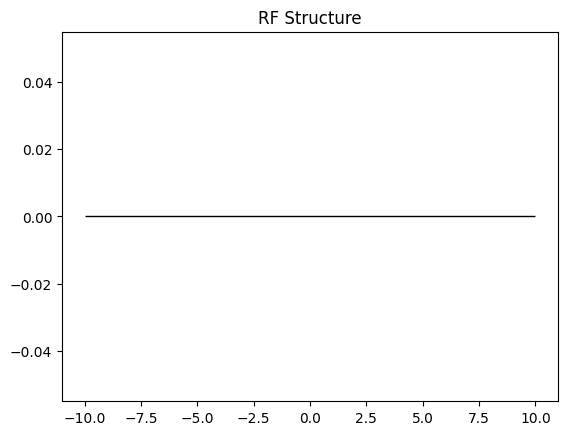

In [22]:
d=plt.hist(HODOraw-bb_rftime,histtype='step',bins=100,range=(-10,10),color='black')
plt.title("RF Structure")

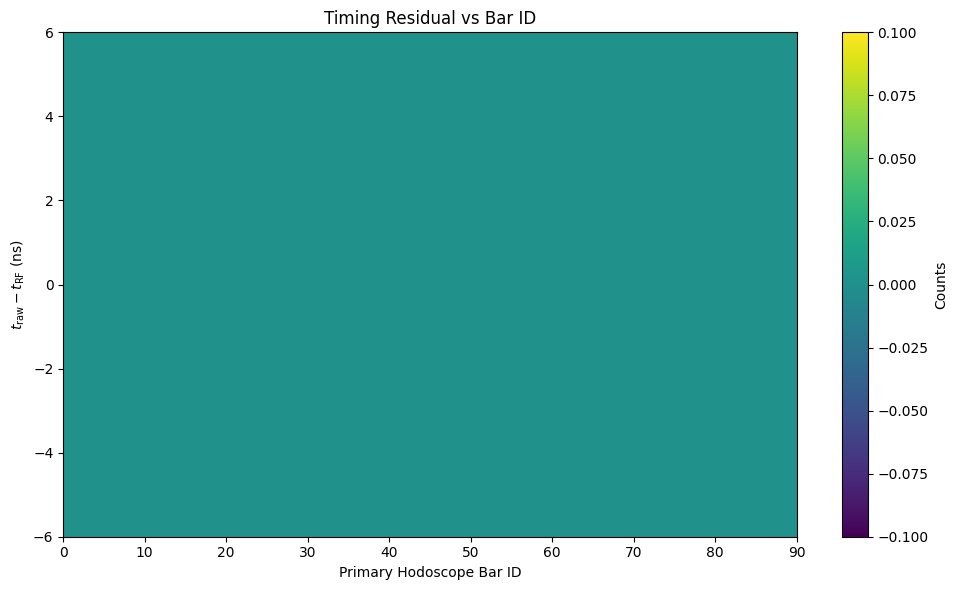

In [23]:
n_bars=90
bins_y=40
y_range=(-6, 6)
dtRF = HODOraw - bb_rftime

# Ensure valid data
primarybarid = primarybarid.astype(int)
valid = (
    (primarybarid >= 0) & (primarybarid < n_bars) &
    np.isfinite(dtRF) & (np.abs(dtRF) < abs(y_range[1]))
)

bars = primarybarid[valid]
times = dtRF[valid]

# Plot
plt.figure(figsize=(10, 6))
h = plt.hist2d(bars, times, bins=[n_bars, bins_y], range=[[0, n_bars], list(y_range)], cmap='viridis')
plt.colorbar(h[3], label='Counts')
plt.xlabel("Primary Hodoscope Bar ID")
plt.ylabel(r"$t_\mathrm{raw} - t_\mathrm{RF}$ (ns)")
plt.title("Timing Residual vs Bar ID")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Time of flight')

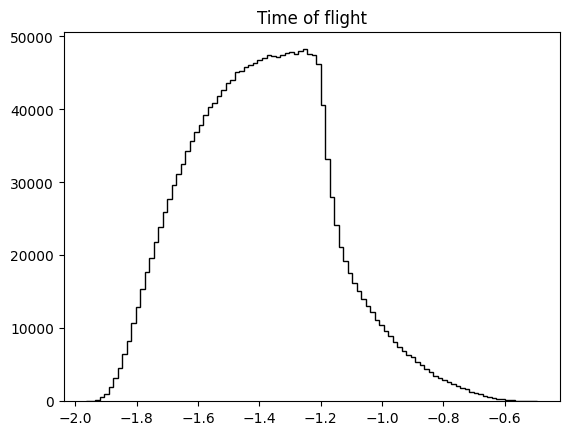

In [24]:
d=plt.hist(pathl/c-etof0,histtype='step',bins=100,color='black')
plt.title("Time of flight")

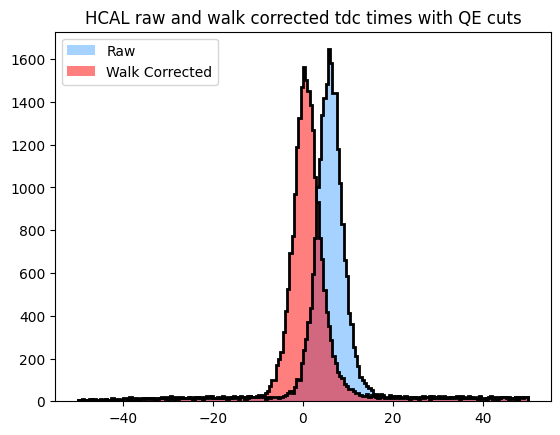

In [25]:
d=plt.hist(tdctimeblk[cut],histtype='step',bins=200,linewidth=2,range=(-50,50),color='black')
d=plt.hist(tdctimeblk[cut],bins=200,linewidth=.5,range=(-50,50),color='dodgerblue',alpha=.4,label='Raw')

d=plt.hist(HCALtw[cut],histtype='step',bins=200,linewidth=2,range=(-50,50),color='black')
d=plt.hist(HCALtw[cut],bins=200,linewidth=.5,range=(-50,50),color='red',alpha=.5,label="Walk Corrected")
plt.title("HCAL raw and walk corrected tdc times with QE cuts")
plt.legend(loc='upper left')

Window width: 5.177250487485796


15321

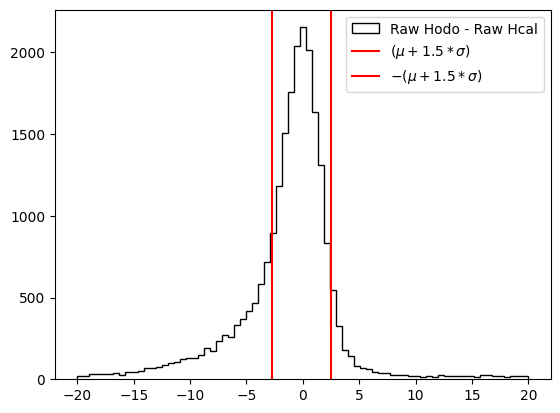

In [26]:
hist_vals, bin_edges = np.histogram(HODOraw[cut] - tdctimeblk[cut], bins=75, range=(-20, 20))
A,mu,sig=GaussFit(hist_vals,bin_edges,plot=False)
d=plt.hist(HODOraw[cut] - tdctimeblk[cut], bins=75,histtype='step',color='black', range=(-20, 20),
          label='Raw Hodo - Raw Hcal')

minval=mu-1.5*sig
maxval=mu+1.5*sig
plt.axvline(maxval,color='red',label=r"$(\mu+1.5*\sigma)$")
plt.axvline(minval,color='red',label=r"$-(\mu+1.5*\sigma)$")

plt.legend(loc="upper right")
print(f"Window width: {3*sig}")

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
mask = (bin_centers >= minval) & (bin_centers <= maxval)
np.sum(hist_vals[mask])

In [27]:
len(np.transpose(barid)[0])

2000000

Window width: 5.022763492509177


13649

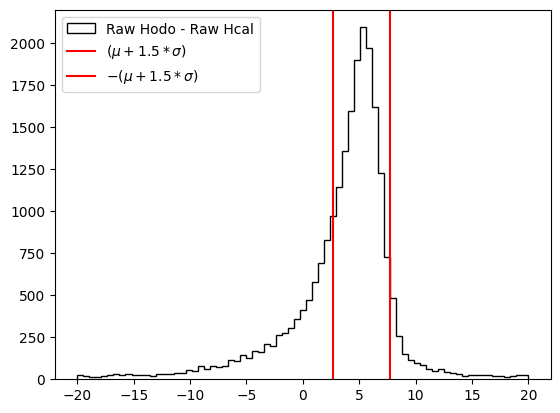

In [28]:
hist_vals, bin_edges = np.histogram(HODOraw[cut] - HCALtw[cut], bins=75, range=(-20, 20))
A,mu,sig=GaussFit(hist_vals,bin_edges,fit_range=(3,10),plot=False)
np.arange(-(mu+1.5*sig),mu+1.5*sig)
d=plt.hist(HODOraw[cut] - HCALtw[cut], bins=75,histtype='step',color='black', range=(-20, 20),
          label='Raw Hodo - Raw Hcal')

minval=mu-1.5*sig
maxval=mu+1.5*sig
plt.axvline(maxval,color='red',label=r"$(\mu+1.5*\sigma)$")
plt.axvline(minval,color='red',label=r"$-(\mu+1.5*\sigma)$")

plt.legend(loc="upper left")
print(f"Window width: {3*sig}")

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
mask = (bin_centers >= minval) & (bin_centers <= maxval)
np.sum(hist_vals[mask])

# Meantime Offsets - Loop 1

In [39]:
def Loop1_partial(
    tleft, tright, totleft, totright, barid, vpos, nbars,
    vz, pathl, xtrack, ytrack, thtrack, phtrack,
    wL, wR, vscint, etof0, zhodo, Lbar_hodo, ref_bar=44,
    n_bars_total=90
):
    # Initialize the linear system: M * offsets = b
    Minternal = np.zeros((n_bars_total, n_bars_total))  # Matrix for bar-to-bar constraints
    binternal = np.zeros(n_bars_total)                  # Vector for bar mean differences
    nevent_vs_bar = np.zeros(n_bars_total)              # Track number of contributing events per bar

    for i in range(len(nbars)):
        # Progress printout every 10k events
        if i % 10000 == 0:
            progress = (f"{i/len(nbars)*100:.4f}% complete\r")
            sys.stdout.write(progress)
            sys.stdout.flush()

        n = nbars[i]
        if n < 2:
            continue  # Need at least two bars in a cluster to build constraints

        # Track projections to hodoscope plane
        yhodo = ytrack[i] + zhodo * phtrack[i]  # projected vertical position
        xhodo = xtrack[i] + zhodo * thtrack[i]  # projected horizontal position

        # Electron time-of-flight correction from vertex to hodoscope
        etof = pathl[i] / c - etof0

        # Lists to store valid bar info for this event
        tmeancorr = []  # corrected meantime per bar
        barids = []     # bar ID for each valid hit

        for j in range(n):
            b = int(barid[i, j])
            if b < 0 or b >= n_bars_total:
                continue  # Skip invalid bar IDs

            # Grab raw values
            tL = tleft[i, j]
            tR = tright[i, j]
            TOTL = totleft[i, j]
            TOTR = totright[i, j]
            xpos = vpos[i, j]
            vsc = vscint[b]

            # Propagation distances from PMTs
            dLEFT = np.clip(Lbar_hodo / 2 - yhodo, 0, Lbar_hodo)
            dRIGHT = np.clip(Lbar_hodo / 2 + yhodo, 0, Lbar_hodo)

            # Apply walk, etof, and propagation corrections
            tL_corr = tL - etof - wL[b] * TOTL - dLEFT / vsc
            tR_corr = tR - etof - wR[b] * TOTR - dRIGHT / vsc

            # Meantime and asymmetry
            tmean_corr = 0.5 * (tL_corr + tR_corr)
            tdiff_corr = tL_corr - tR_corr
            ypos = -0.5 * vsc * tdiff_corr  # inferred vertical position

            # Save tmean0 from the first valid bar to compare others
            if j == 0:
                tmean0 = tmean_corr

            # Apply hit quality cuts (same as in TOFcal)
            good = (
                6 <= TOTL <= 35 and
                6 <= TOTR <= 35 and
                abs(TOTL - TOTR) <= 10 and
                abs(ypos - yhodo) <= 0.15 and
                abs(xpos - xhodo) <= 0.06 and
                abs(tmean_corr - tmean0) <= 10
            )

            if good:
                tmeancorr.append(tmean_corr)
                barids.append(b)

        # Build bar-pair constraints
        for a in range(len(barids)):
            for b in range(a + 1, len(barids)):
                ida = barids[a]
                idb = barids[b]
                ta = tmeancorr[a]
                tb = tmeancorr[b]

                # Add symmetric constraints:
                # offset[ida] - offset[idb] ≈ ta - tb
                Minternal[ida, ida] += 1
                Minternal[idb, idb] += 1
                Minternal[ida, idb] += -1
                Minternal[idb, ida] += -1
                binternal[ida] += ta - tb
                binternal[idb] += tb - ta
                nevent_vs_bar[ida] += 1
                nevent_vs_bar[idb] += 1

    return Minternal, binternal, nevent_vs_bar
M_total = np.zeros((90, 90))
b_total = np.zeros(90)
nevents_total = np.zeros(90)





In [40]:
#Chunkloading
base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/Timing"
i=0
while os.path.exists(f"{base_dir}/timing{i}.npz"):
    # load your i-th chunk here
    data = np.load(f"{base_dir}/timing{i}.npz")  # or .npy/.h5 depending on your format

    M, b, nev = Loop1_partial(
        data["tleft"], data["tright"], data["totleft"], data["totright"], data["barid"],
        data["vpos"], data["nbars"], data["vz"], data["pathl"],
        data["tr_x"], data["tr_y"], data["tr_th"], data["tr_ph"],
        wL, wR, vscint, etof0,
        zhodo, Lbar_hodo
    )

    M_total += M
    b_total += b
    nevents_total += nev
    i+=1

# Regularize
for i in range(90):
    if nevents_total[i] < 100:
        print(f"Bar {i} too low stats")
        b_total[i] = 0.0
        M_total[i, :] = 0.0
        M_total[:, i] = 0.0
        M_total[i, i] = 1.0

# Solve
offsets2 = np.linalg.lstsq(M_total, b_total, rcond=None)[0]
offsets2 -= offsets2[44]  # Normalize to bar 44


Bar 30 too low stats
Bar 89 too low stats


In [41]:
confirm = input("Are you sure you want to overwrite the file? (yes/no): ")
if confirm.lower() == "yes":
    np.save(f"DB/timing/hodomeantime_offsets_gen{config}.npy", offsets2)
    print("File saved.")
else:
    print("Save canceled.")

Are you sure you want to overwrite the file? (yes/no): yes
File saved.


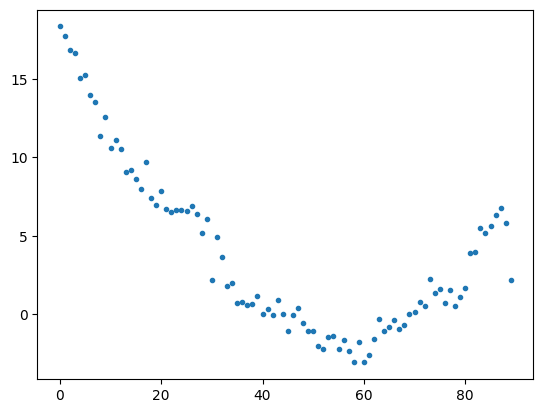

In [29]:
plt.plot(hodomeantime_gen2,'.')

In [ ]:
offsets, Minternal, binternal, nevent_vs_bar = Loop1(
    tleft, tright, totleft, totright, barid, vpos, nbars,
    vz, pathl, tr_x, tr_y, tr_th, tr_ph,
    wL, wR, vscint,
    etof0,         # adjust this if you have a known etof0 offset
    zhodo,          # hodoscope z offset from target
    Lbar_hodo,      # total length of hodoscope bar in meters
    ref_bar=44          # reference bar for offset normalization
)

In [274]:
offsets

array([ 5.78946675, 10.37464886,  9.69617545,  9.22495024,  7.58139173,
        7.78437362,  6.46463271,  5.78946675,  5.78946675,  6.79336546,
        4.95458477,  5.81368152,  5.78946675,  5.78946675,  6.64091831,
        6.70819578,  6.50488047,  9.04953688,  6.69159377,  6.13664303,
        7.22182151,  6.39162827,  6.29637308,  6.38013452,  6.42219742,
        6.32527544,  6.56934721,  6.35300928,  5.44101961,  6.09116447,
        5.78946675,  5.37947842,  4.01224969,  2.39429006,  2.60752898,
        1.54893983,  1.48438151,  1.44450204,  1.09483553,  1.8633085 ,
        0.13743647,  0.6309356 , -0.02195986,  1.00220885,  0.        ,
       -1.32148826, -0.15829708,  0.535356  , -0.68447429, -1.25070487,
       -1.0104717 , -2.22204354, -2.36921608, -1.80070393, -1.64604936,
       -2.22718234, -1.54944417, -2.45811754, -3.03590344, -1.79095492,
       -2.76242187, -2.43158763, -1.47684916, -0.21746264, -1.19663827,
       -0.67552161, -0.2938685 , -0.97070765, -0.72192501, -0.03

In [ ]:
offsets

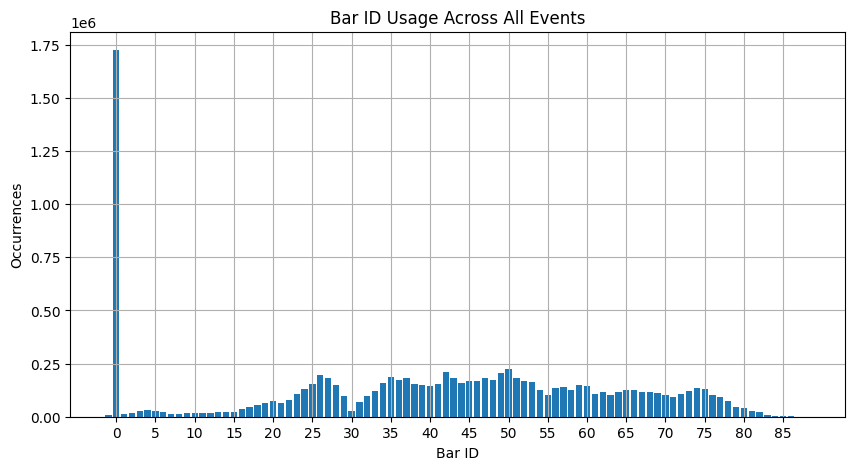

In [235]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten and filter valid barids (0 to 89)
valid_barids = barid

# Count occurrences
unique_bars, counts = np.unique(valid_barids, return_counts=True)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(unique_bars, counts, width=0.8)
plt.xlabel("Bar ID")
plt.ylabel("Occurrences")
plt.title("Bar ID Usage Across All Events")
plt.xticks(np.arange(0, 90, 5))
plt.grid(True)
plt.show()


In [241]:
HODOtcorr = []

for i in range(len(HODOraw)):
    if nbars[i] > 0:
        primary_id = int(barid[i][0])  # assume first is primary
        if 0 <= primary_id < len(offsets):
            corrected = HODOraw[i] - offsets[primary_id]
        else:
            corrected = HODOraw[i]
    else:
        corrected = HODOraw[i]

    HODOtcorr.append(corrected)

HODOtcorr = np.array(HODOtcorr)


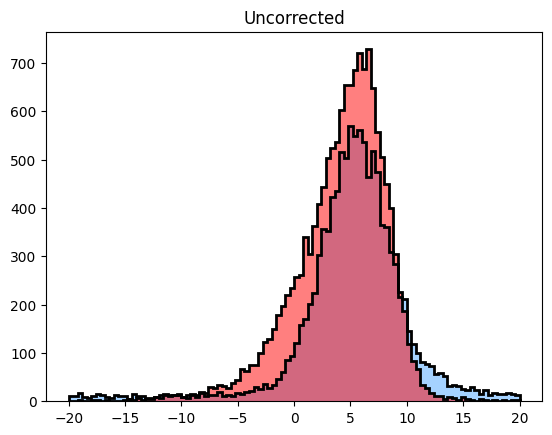

In [268]:

plt.title("Uncorrected")
binrange=20
d=plt.hist(tdctimeblk[cut],histtype='step',bins=100,linewidth=2,range=(-binrange,binrange),color='black')
d=plt.hist(tdctimeblk[cut],bins=100,linewidth=.5,range=(-binrange,binrange),color='dodgerblue',alpha=.4)

d=plt.hist(HODOraw[cut],histtype='step',bins=100,linewidth=2,range=(-binrange,binrange),color='black')
d=plt.hist(HODOraw[cut],bins=100,linewidth=.5,range=(-binrange,binrange),color='red',alpha=.5)



Text(0.5, 1.0, 'GEN2:  hcal.tdctimblk - hodotdc.clus.tmean')

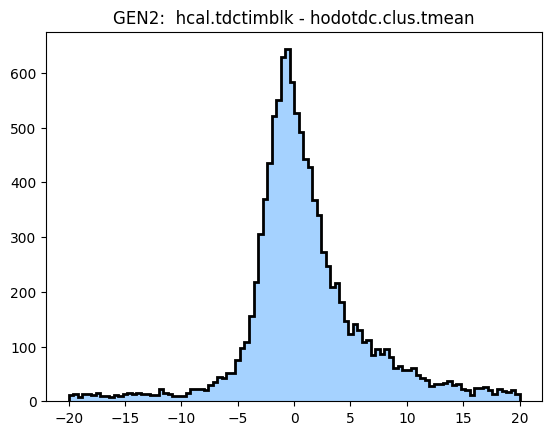

In [299]:
d=plt.hist(tdctimeblk[cut]-HODOraw[cut],histtype='step',bins=100,linewidth=2,range=(-20,20),color='black')
d=plt.hist(tdctimeblk[cut]-HODOraw[cut],bins=100,linewidth=.5,range=(-20,20),color='dodgerblue',alpha=.4)
plt.title(f"GEN{config}:  hcal.tdctimblk - hodotdc.clus.tmean")

In [104]:
len(tdctimeblk)

1724164

# Walk Corrections

In [275]:
import numpy as np

def solve_walk_and_prop_corrections(
    tleft, tright, totleft, totright, vpos, barid, nbars,
    vz, pathl, xtrack, ytrack, thtrack, phtrack,
    MeanTimeOffsets,
    etof0=30.0, zhodo=1.8, Lbar_hodo=0.9,
    n_bars=90, min_events_per_bar=50
):
    c = 0.299792458
    nparams = 3 * n_bars  # t0, wL, wR per bar
    Mhodo = np.zeros((nparams, nparams))
    bhodo = np.zeros(nparams)
    event_counts = np.zeros(n_bars)

    for i in range(len(nbars)):
        n = nbars[i]
        if n < 1:
            continue

        yhodo = ytrack[i] + zhodo * phtrack[i]
        xhodo = xtrack[i] + zhodo * thtrack[i]
        etof = pathl[i] / c - etof0

        for j in range(n):
            b = int(barid[i, j])
            if b < 0 or b >= n_bars:
                continue

            # Hit-level quantities
            tL = tleft[i, j]
            tR = tright[i, j]
            TOTL = totleft[i, j]
            TOTR = totright[i, j]
            xpos = vpos[i, j]

            # Geometry
            dLEFT = np.clip(Lbar_hodo / 2 - yhodo, 0, Lbar_hodo)
            dRIGHT = np.clip(Lbar_hodo / 2 + yhodo, 0, Lbar_hodo)

            # Raw times corrected only for etof and offset
            tL_corr = tL - etof - MeanTimeOffsets[b]
            tR_corr = tR - etof - MeanTimeOffsets[b]

            # Meantime + asymmetry
            tmean = 0.5 * (tL_corr + tR_corr)
            tdiff = tL_corr - tR_corr
            ypos = -0.5 * dLEFT * tdiff

            # Hit quality cuts
            if not (
                6 <= TOTL <= 35 and
                6 <= TOTR <= 35 and
                abs(TOTL - TOTR) <= 10 and
                abs(ypos - yhodo) <= 0.15 and
                abs(xpos - xhodo) <= 0.06
            ):
                continue

            event_counts[b] += 1

            # Matrix indices
            i_t0 = b
            i_wL = b + n_bars
            i_wR = b + 2 * n_bars

            # Left PMT
            Mhodo[i_t0, i_t0] += 1
            Mhodo[i_t0, i_wL] += -TOTL
            Mhodo[i_wL, i_t0] += -TOTL
            Mhodo[i_wL, i_wL] += TOTL**2
            bhodo[i_t0] += tL_corr
            bhodo[i_wL] += -tL_corr * TOTL

            # Right PMT
            Mhodo[i_t0, i_t0] += 1
            Mhodo[i_t0, i_wR] += -TOTR
            Mhodo[i_wR, i_t0] += -TOTR
            Mhodo[i_wR, i_wR] += TOTR**2
            bhodo[i_t0] += tR_corr
            bhodo[i_wR] += -tR_corr * TOTR

    # Regularize underpopulated bars
    for b in range(n_bars):
        if event_counts[b] < min_events_per_bar:
            for idx in [b, b + n_bars, b + 2 * n_bars]:
                Mhodo[idx, :] = 0
                Mhodo[:, idx] = 0
                Mhodo[idx, idx] = 1
                bhodo[idx] = 0.0

    # Solve
    params = np.linalg.lstsq(Mhodo, bhodo, rcond=None)[0]
    t0 = params[0:n_bars]
    wL = params[n_bars:2*n_bars]
    wR = params[2*n_bars:3*n_bars]
    vscint = np.full(n_bars, 0.13)  # placeholder for now

    return t0, wL, wR, vscint, event_counts


In [277]:
HODOt0, HODOwL, HODOwR, vscint_fixed, event_counts = solve_walk_and_prop_corrections(
    tleft, tright, totleft, totright, vpos, barid, nbars,
    vz, pathl, tr_x, tr_y, tr_th, tr_ph,
    offsets,
    etof0
)


In [278]:
def apply_final_hodo_corrections(
    tleft, tright, totleft, totright, vpos, barid, nbars,
    pathl, MeanTimeOffsets, wL, wR, vscint,
    etof0=30.0, c=0.299792458, Lbar_hodo=0.9, zhodo=1.8,
    xtrack=None, ytrack=None, thtrack=None, phtrack=None
):
    """
    Applies all final hodoscope corrections (walk, propagation, etof, t0 offset) to each hit
    and returns a per-event final corrected mean time using the primary bar (bar 0 in each event).
    """
    n_events = len(nbars)
    HODO_final = np.full(n_events, np.nan)

    for i in range(n_events):
        if nbars[i] < 1:
            continue

        b = int(barid[i][0])  # primary bar only
        if b < 0 or b >= len(wL):
            continue

        # Pull values
        tL = tleft[i][0]
        tR = tright[i][0]
        TOTL = totleft[i][0]
        TOTR = totright[i][0]
        vsc = vscint[b]

        # Optional: get geometry from track projection
        if xtrack is not None and ytrack is not None and thtrack is not None and phtrack is not None:
            yhodo = ytrack[i] + zhodo * phtrack[i]
            dLEFT = np.clip(Lbar_hodo / 2 - yhodo, 0, Lbar_hodo)
            dRIGHT = np.clip(Lbar_hodo / 2 + yhodo, 0, Lbar_hodo)
        else:
            # Fallback if no track info: symmetric prop distances
            dLEFT = dRIGHT = Lbar_hodo / 2

        etof = pathl[i] / c - etof0

        # Apply all corrections
        tL_corr = tL - etof + wL[b]*TOTL - MeanTimeOffsets[b] - dLEFT / vsc
        tR_corr = tR - etof + wR[b]*TOTR - MeanTimeOffsets[b] - dRIGHT / vsc
        HODO_final[i] = 0.5 * (tL_corr + tR_corr)

    return HODO_final


In [280]:
HODO_final = apply_final_hodo_corrections(
    tleft, tright, totleft, totright, vpos, barid, nbars,
    pathl, offsets, HODOwL, HODOwR, vscint_fixed,
    xtrack=tr_x, ytrack=tr_y, thtrack=tr_th, phtrack=tr_ph
)


(array([3.20000e+02, 2.50400e+03, 1.35320e+04, 1.03524e+05, 4.86802e+05,
        5.56163e+05, 7.26710e+04, 1.55900e+03, 8.01000e+02, 8.00000e+01]),
 array([-25.11973492, -17.36908815,  -9.61844139,  -1.86779462,
          5.88285215,  13.63349891,  21.38414568,  29.13479245,
         36.88543921,  44.63608598,  52.38673275]),
 <BarContainer object of 10 artists>)

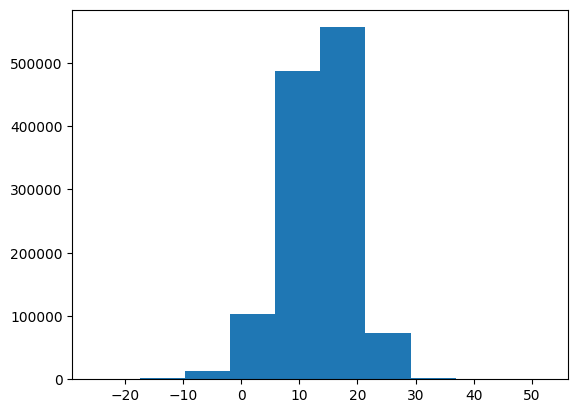

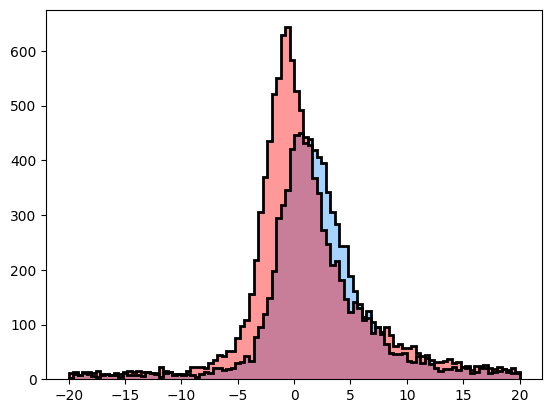

In [290]:
d=plt.hist(HCALtw[cut]-HODO_final[cut]+18,histtype='step',bins=100,linewidth=2,range=(-20,20),color='black')
d=plt.hist(HCALtw[cut]-HODO_final[cut]+18,bins=100,linewidth=.5,range=(-20,20),color='dodgerblue',alpha=.4)

d=plt.hist(tdctimeblk[cut]-HODOraw[cut],histtype='step',bins=100,linewidth=2,range=(-20,20),color='black')
d=plt.hist(tdctimeblk[cut]-HODOraw[cut],bins=100,linewidth=.5,range=(-20,20),color='red',alpha=.4)

# RF Offsets

In [258]:
def compute_rf_offsets_loop2(
    tleft, tright, totleft, totright, vpos, barid, nbars,
    vz, pathl, xtrack, ytrack, thtrack, phtrack,
    MeanTimeOffsets,
    bb_rftime,
    etof0, zhodo, Lbar_hodo,wL_default, wR_default, vscint_default,
    bunch_spacing=160.321,
    c=0.299792458,
    
):
    """
    Loop 2: Use default wL, wR, vscint and MeanTimeOffsets (from Loop 1)
    to calculate t_HODO - RF per bar and return for histogramming.
    """
    dtRF_list = []
    barid_list = []
    globalcut=(abs(bb_trigtime)<1e5)&(abs(bb_rftime<1e5))

    for i in range(len(nbars)):
        if not globalcut[i]:
            continue
        n = nbars[i]
        if n < 1 or not np.isfinite(bb_rftime[i]) or not np.isfinite(pathl[i]):
            continue

        RF_corr = bb_rftime[i] + vz[i] / c
        etof = pathl[i] / c - etof0
        yhodo = ytrack[i] + zhodo * phtrack[i]
        xhodo = xtrack[i] + zhodo * thtrack[i]

        dLEFT = np.clip(Lbar_hodo / 2 - yhodo, 0, Lbar_hodo)
        dRIGHT = np.clip(Lbar_hodo / 2 + yhodo, 0, Lbar_hodo)

        tmean0 = None
        for j in range(n):
            
            b = int(barid[i, j])
            if b < 0 or b >= 90:
                continue

            tL = tleft[i, j]
            tR = tright[i, j]
            TOTL = totleft[i, j]
            TOTR = totright[i, j]
            xpos = vpos[i, j]

            # Use defaults
            wL = wL_default
            wR = wR_default
            vsc = vscint_default

            # Corrections
            tL_corr = tL - etof + wL * TOTL - MeanTimeOffsets[b] - dLEFT / vsc
            tR_corr = tR - etof + wR * TOTR - MeanTimeOffsets[b] - dRIGHT / vsc
            tHODO = 0.5 * (tL_corr + tR_corr)
            tdiff = tL_corr - tR_corr
            ypos = -0.5 * vsc * tdiff

            if tmean0 is None and np.isfinite(tHODO):
                tmean0 = tHODO


            good = (
                6 <= TOTL <= 35 and
                6 <= TOTR <= 35 and
                abs(TOTL - TOTR) <= 10 and
                abs(ypos - yhodo) <= 0.15 and
                abs(xpos - xhodo) <= 0.06 and
                abs(tHODO - tmean0) <= 10
            )

            if good:
                dtRF = tHODO - RF_corr
                dtRF_wrapped = dtRF - bunch_spacing * (np.floor(dtRF / bunch_spacing) + 0.5)
                dtRF_list.extend([dtRF_wrapped, dtRF_wrapped - bunch_spacing, dtRF_wrapped + bunch_spacing])
                barid_list.extend([b, b, b])

    return np.array(barid_list), np.array(dtRF_list)


In [259]:
barids_rf, dt_rf = compute_rf_offsets_loop2(
    tleft, tright, totleft, totright, vpos, barid, nbars,
    vz, pathl, tr_x, tr_y, tr_th, tr_ph,
    offsets,
    sbs_rftime,
    etof0, zhodo, Lbar_hodo,wL_default, wR_default, vscint_default,
    bunch_spacing=160.321,
    c=0.299792458,
    
)



In [260]:
def plot_dtRF_histogram(barids, dtRF, nbars=90, range_ns=(-480, 480)):
    plt.figure(figsize=(10, 6))
    plt.hist2d(barids, dtRF, bins=[nbars, 150], range=[[-0.5, nbars - 0.5], list(range_ns)], cmap='viridis')
    plt.xlabel("Bar ID")
    plt.ylabel("t_HODO - RF (ns)")
    plt.title("Hodoscope Timing Residuals after Loop 1")
    plt.colorbar(label="Counts")
    plt.tight_layout()
    plt.show()


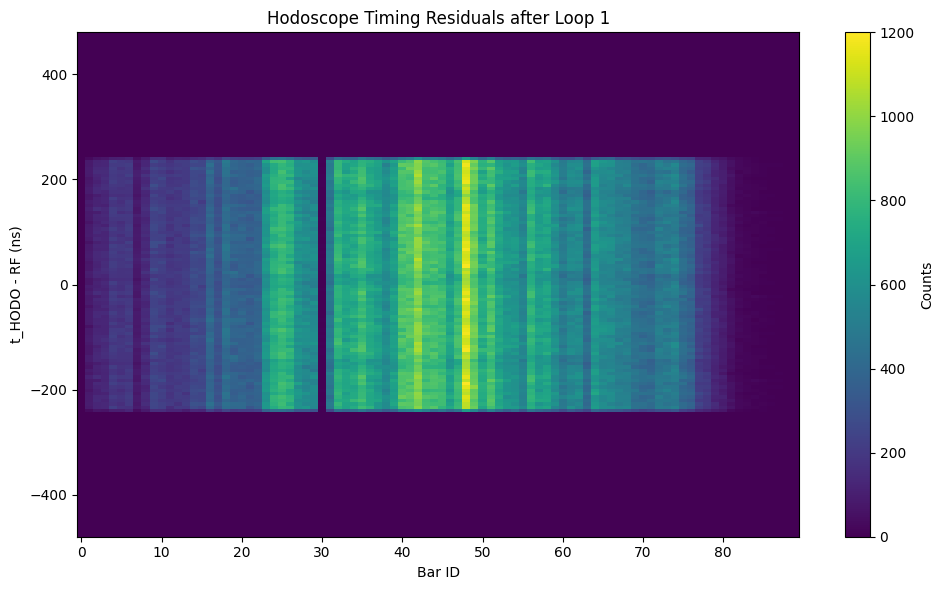

In [261]:
plot_dtRF_histogram(barids_rf, dt_rf)


In [295]:
d=plt.hist(dt_rf,bins=100)

ValueError: operands could not be broadcast together with shapes (1724164,) (3069867,) 

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def extract_rf_offsets_with_plots(barids_rf, dt_rf, nbars=90, bins=150, dt_range=(-480, 480), entries_threshold=500, ref_bar=44, output_pdf="RFoffsets_debug.pdf"):
    """
    Extracts RF offsets per bar by fitting gaussians to dt_RF distributions.
    Saves plots of each bar's spectrum and fitted gaussian into a PDF.
    """
    # Create histograms for each bar
    bin_edges = np.linspace(*dt_range, bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    hists = [np.histogram(dt_rf[barids_rf == b], bins=bin_edges)[0] for b in range(nbars)]

    RFoffsets = np.full(nbars, np.nan)
    dRFoffsets = np.full(nbars, np.nan)

    with PdfPages(output_pdf) as pdf:
        xtest = None

        for direction in ["right", "left"]:
            bar_range = range(ref_bar + 1, nbars) if direction == "right" else range(ref_bar - 1, -1, -1)

            if direction == "right":
                # Fit reference bar first
                y = hists[ref_bar]
                if np.sum(y) < entries_threshold:
                    continue

                peaks, _ = find_peaks(y, height=np.max(y)*0.3)
                if len(peaks) == 0:
                    continue

                ref_peak_idx = peaks[np.argmin(np.abs(bin_centers[peaks]))]
                xtest = bin_centers[ref_peak_idx]

                # Fit gaussian
                try:
                    popt, pcov = curve_fit(gaussian, bin_centers[ref_peak_idx-5:ref_peak_idx+6], y[ref_peak_idx-5:ref_peak_idx+6], p0=[y[ref_peak_idx], xtest, 2.0])
                    RFoffsets[ref_bar] = popt[1]
                    dRFoffsets[ref_bar] = np.sqrt(np.diag(pcov))[1]
                except Exception as e:
                    print(f"Ref bar {ref_bar} fit failed: {e}")
                    continue

                # Plot
                fig, ax = plt.subplots()
                ax.plot(bin_centers, y, label=f'Bar {ref_bar}')
                ax.plot(bin_centers, gaussian(bin_centers, *popt), label='Gaussian Fit')
                ax.set_title(f'RF Offset Fit - Bar {ref_bar}')
                ax.legend()
                pdf.savefig(fig)
                plt.close()

            for bar in bar_range:
                y = hists[bar]
                if np.sum(y) < entries_threshold:
                    continue

                peaks, _ = find_peaks(y, height=np.max(y)*0.3)
                if len(peaks) == 0 or xtest is None:
                    continue

                best_idx = peaks[np.argmin(np.abs(bin_centers[peaks] - xtest))]
                xpeak_best = bin_centers[best_idx]

                try:
                    window = (max(0, best_idx - 5), min(len(bin_centers), best_idx + 6))
                    popt, pcov = curve_fit(gaussian, bin_centers[window[0]:window[1]], y[window[0]:window[1]], p0=[y[best_idx], xpeak_best, 2.0])
                    RFoffsets[bar] = popt[1]
                    dRFoffsets[bar] = np.sqrt(np.diag(pcov))[1]
                    xtest = popt[1]
                except Exception as e:
                    print(f"Bar {bar} fit failed: {e}")
                    continue

                # Plot
                fig, ax = plt.subplots()
                ax.plot(bin_centers, y, label=f'Bar {bar}')
                ax.plot(bin_centers, gaussian(bin_centers, *popt), label='Gaussian Fit')
                ax.set_title(f'RF Offset Fit - Bar {bar}')
                ax.legend()
                pdf.savefig(fig)
                plt.close()

    return RFoffsets, dRFoffsets


In [264]:
RFoffsets, dRFoffsets = extract_rf_offsets_with_plots(
    barids_rf, dt_rf,
    ref_bar=44,
    output_pdf="RFoffsets_debug.pdf"
)


Ref bar 44 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 43 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 41 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 40 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 39 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 37 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 31 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 29 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 16 fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Bar 13 fit failed: Optimal parameters not found: Number of calls to f